In [20]:
import numpy as np
import matplotlib.pyplot as plt
import copy

In [21]:
data = np.load(file = "final_pulsar_data.npy")
data.shape

(32, 254)

---

In [22]:
freqmax = 800.0  #MHz
freqmin = 400.0  #MHz
freq_nbins = data.shape[0]
freq_binsize = (freqmax-freqmin)/freq_nbins

t_nbins = data.shape[1]
t_binsize = 16.0 #ms
t_max = t_nbins*t_binsize

print(freq_binsize, t_max)

12.5 4064.0


In [23]:
time_bins = np.linspace(0, t_max, t_nbins, dtype= float )
freq_bins = np.linspace(freqmax, freqmin, freq_nbins, dtype=float)

---


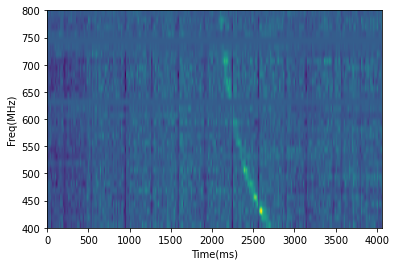

In [24]:
plt.imshow(data, aspect = "auto", extent = [0, t_max, freqmin, freqmax])
plt.xlabel("Time(ms)")
plt.ylabel("Freq(MHz)")
plt.show()

---


---

Useful functions:

- delay(DM, freq)

- shift_back(channels, delay)

- time_series(channels)

- SNR(time_serie)

In [25]:
def delay(DM, freq):
    #freq in MHz
    return 4.148808e3 * DM *  (freq**(-2)) *1000  #returns delay in ms 

In [26]:
print(delay(5, np.array([1,2,3,4,5], float)))

[20744040.          5186010.          2304893.33333333  1296502.5
   829761.6       ]


---

In [27]:
def shift_back_single(channel, delay):
    #shifts a frequency channel back by a delay in ms 
    #number of bins to shift the channel by
    shift_amount = round(delay/t_binsize)   
    return np.roll(channel,-shift_amount)


def shift_back(channels, delays):
    #assuming len(delays) = len(channels) i.e. 1 delay is given for each channel
    n_channels = len(channels)
    channels1 = np.zeros(channels.shape)
    for i in range(n_channels):
        channels1[i] = shift_back_single(channels[i], delays[i])
    return channels1
    


In [28]:
channels = np.array([[1,2,3,4,5], [6,7,8,9,10]])
x = shift_back(channels, np.array([16,32]))
print(x)

[[ 2.  3.  4.  5.  1.]
 [ 8.  9. 10.  6.  7.]]


---

In [29]:
def time_series(channels):
    #add over all frequency channels
    return np.sum(channels, axis=0)

In [30]:
ts = time_series(x)
print(ts)

[10. 12. 14. 11.  8.]


---

In [31]:
def SNR(time_serie):
    signal = np.max(np.abs(time_serie))
    noise = np.mean(np.abs(time_serie))
    return signal/noise

In [32]:
snr = SNR(ts)
print(snr)

1.2727272727272727


---

---

Trial

Unshifted data

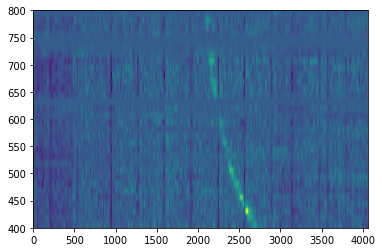

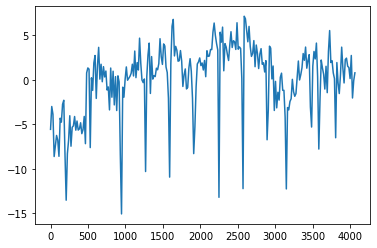

4.981792


In [33]:
plt.imshow(data, aspect = "auto", extent = [0, t_max, freqmin, freqmax])
plt.show()
timeser = time_series(data)
plt.plot(time_bins, timeser)
plt.show()
print(SNR(timeser))

Shifted data

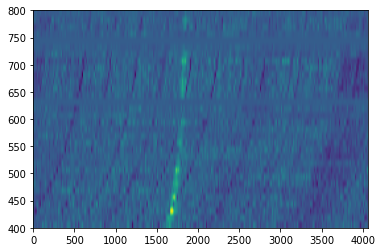

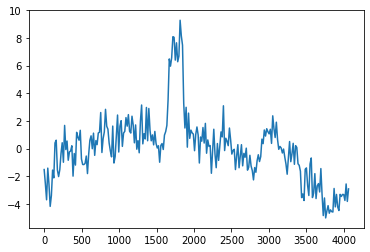

5.417749046836076


In [34]:
delays = delay(40, freq_bins)
shifted_data = shift_back(data, delays)
plt.imshow(shifted_data, aspect = "auto", extent = [0, t_max, freqmin, freqmax])
plt.show()
timeser = time_series(shifted_data)
plt.plot(time_bins, timeser)
plt.show()
print(SNR(timeser))

---

finding optimal shift to calculate DM

In [35]:
def find_best_DM(channels, DMstart, DMend, DMstep, display = False):
    snrmax = 0
    DMbest = DMstart
    best_shifted_channels = np.zeros(channels.shape)
    best_time_ser = np.array([0 for i in range(t_nbins)])
    
    snrvsdm = [[],[]]
    
    for DM in np.arange(DMstart, DMend, DMstep):
        delays = delay(DM, freq_bins)
        shifted_channels = shift_back(channels, delays)
        timeser = time_series(shifted_channels)
        snr = SNR(timeser)
        
        snrvsdm[0].append(DM)
        snrvsdm[1].append(snr)
        
        if(snr>snrmax):
            #print(DM, snr)
            snrmax = snr
            DMbest = DM
            best_shifted_channels = shifted_channels
            best_time_ser = timeser

    if(display):
        plt.imshow(best_shifted_channels, aspect = "auto", extent = [0, t_max, freqmin, freqmax])
        #plt.title(f"Dynamic Power Spectrum, DM = {DMbest}")
        plt.xlabel("Time(ms)")
        plt.ylabel("Freq(MHz)")
        plt.show()
        
        plt.plot(time_bins, best_time_ser)
        #plt.title("Time series spectrum (de-dispersed)")
        plt.ylabel("Signal strength")
        plt.xlabel("Time(ms)")
        plt.show()
        
        plt.scatter(snrvsdm[0], snrvsdm[1], s = 0.01)
        plt.xlabel("DM")
        plt.ylabel("SNR")
        plt.show()
        
        
    return (DMbest, snrmax)


In [36]:
def find_best_DM_fast(data, DMstart, DMend, DMstepmax, DMstepmin):
    #not working as expected
    DMbest = 0
    while(DMstepmax>DMstepmin):
        print(DMstepmax, DMbest)
        DMbest, _ = find_best_DM(data, DMstart, DMend, DMstepmax)
        DMstart = DMbest*0.9
        DMend = DMbest*1.1
        DMstepmax/=10
    return find_best_DM(data, DMstart, DMend, DMstepmin, display=True)

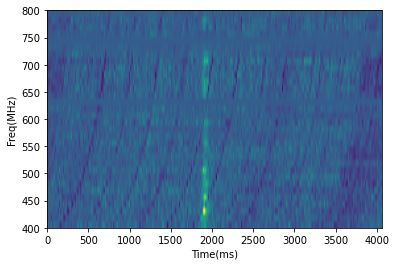

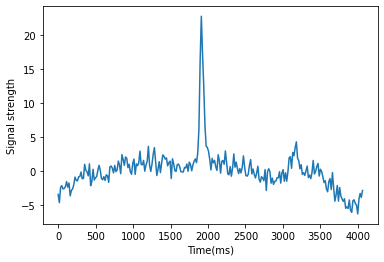

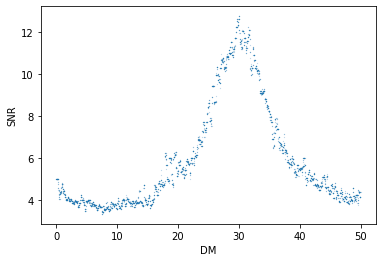

(30.02, 12.746213646532944)

In [37]:

find_best_DM(data, 0, 50, 0.01, display=True)


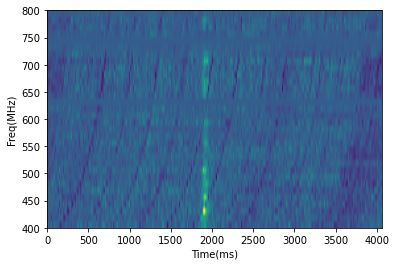

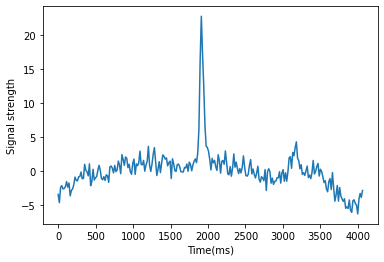

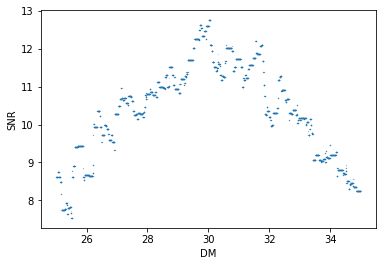

(30.01500000000613, 12.746213646532944)

In [38]:

find_best_DM(data, 25, 35, 0.001, display=True)
